✅ Found dataset directory: /content

--- Directory listing (dataset root) ---
.config                   -> 8 files
sample_data               -> 6 files
----------------------------------------

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.

Class indices (label -> index): {'.config': 0, 'sample_data': 1}
Number of classes: 2
Training samples: 0
Validation samples: 0


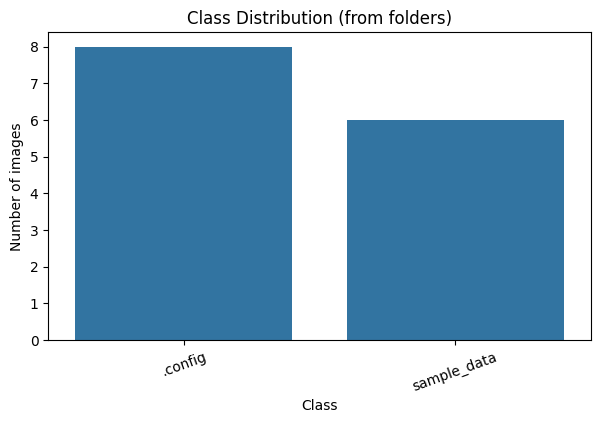


Sample batch shapes -> images: (0, 224, 224, 3) , labels: (0, 2)


<Figure size 800x800 with 0 Axes>


One-hot encoding example (first 5 labels):
[]

✅ Dataset preparation & preprocessing complete. Ready for model training.


In [9]:
# Works whether you uploaded separate class folders or uploaded a single DATASET.zip
# If dataset folders exist, it will use them.
# If not, and a ZIP exists at /content/DATASET.zip, it will extract it.

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# ---------- User-changeable paths----------
zip_path = "/content/DATASET.zip"   # if you uploaded as zip (optional)
common_candidate_dirs = [
    "/content/dataset",
    "/content/DATASET",
    "/content/data",
    "./dataset",
    "./DATASET",
    "./data",
    "/content"   # last resort - we will search inside
]
EXPECTED_CLASS_NAMES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']  # optional hint
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# ---------- Helper: find a directory that looks like the dataset root ----------
def find_dataset_root(candidates):
    def is_candidate(p):
        if not os.path.isdir(p):
            return False
        # list subdirectories (potential class folders)
        subdirs = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]
        if len(subdirs) >= 2:
            return True
        return False

    # 1) check obvious candidates
    for p in candidates:
        if is_candidate(p):
            return os.path.abspath(p)

    # 2) fallback: search one level deep under /content
    base = "/content"
    if os.path.isdir(base):
        for entry in os.listdir(base):
            p = os.path.join(base, entry)
            if is_candidate(p):
                return os.path.abspath(p)

    # 3) fallback: search current working directory
    base = "."
    for entry in os.listdir(base):
        p = os.path.join(base, entry)
        if is_candidate(p):
            return os.path.abspath(p)

    return None

# ---------- If no dataset folder found, extract zip (only if present) ----------
dataset_root = find_dataset_root(common_candidate_dirs)
if dataset_root:
    print("✅ Found dataset directory:", dataset_root)
else:
    # Try extracting the zip only if it's present and no dataset folder exists
    if os.path.exists(zip_path):
        print("⚠️ Dataset folder not found; attempting to extract ZIP:", zip_path)
        with zipfile.ZipFile(zip_path, 'r') as z:
            # extract to /content/dataset (safe)
            extract_dir = "/content/dataset"
            z.extractall(extract_dir)
            print("✅ Extracted ZIP to:", extract_dir)
        dataset_root = find_dataset_root([extract_dir])
        if dataset_root:
            print("✅ Dataset root found after extraction:", dataset_root)
    else:
        raise FileNotFoundError("No dataset folder found and no ZIP at {}. "
                                "Please upload your dataset folders or DATASET.zip to Colab.".format(zip_path))

# ---------- Final check ----------
if not dataset_root:
    raise RuntimeError("Unable to locate dataset root. Make sure your dataset has subfolders for each class "
                       "(e.g. 'wrinkles', 'dark spots', ...).")

# Print directory listing for diagnosis
print("\n--- Directory listing (dataset root) ---")
for entry in sorted(os.listdir(dataset_root)):
    full = os.path.join(dataset_root, entry)
    if os.path.isdir(full):
        cnt = sum(1 for f in os.listdir(full) if os.path.isfile(os.path.join(full, f)))
        print(f"{entry:25s} -> {cnt} files")
print("----------------------------------------\n")

# ---------- Create ImageDataGenerator (preprocessing + augmentation) ----------
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    dataset_root,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_root,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# ---------- Diagnostics: class indices and sample counts ----------
print("\nClass indices (label -> index):", train_gen.class_indices)
print("Number of classes:", train_gen.num_classes)
print("Training samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)

# ---------- Show class distribution plot ----------
# Compute counts from folder listing (more reliable than generator.samples in weird cases)
class_counts = {}
for cls_name in sorted(train_gen.class_indices.keys()):
    cls_folder = os.path.join(dataset_root, cls_name)
    class_counts[cls_name] = len([f for f in os.listdir(cls_folder) if os.path.isfile(os.path.join(cls_folder, f))])

plt.figure(figsize=(7,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution (from folders)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(rotation=20)
plt.show()

# ---------- Visualize a batch of augmented images and their one-hot labels ----------
images, labels = next(train_gen)  # one batch
print("\nSample batch shapes -> images:", images.shape, ", labels:", labels.shape)
n = min(9, images.shape[0])

plt.figure(figsize=(8,8))
for i in range(n):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    lbl_idx = np.argmax(labels[i])
    # find class name by index
    idx_to_class = {v:k for k,v in train_gen.class_indices.items()}
    plt.title(idx_to_class[lbl_idx])
    plt.axis('off')
plt.suptitle("Augmented image samples (one batch)")
plt.show()

# ---------- One-hot encoding sanity check ----------
print("\nOne-hot encoding example (first 5 labels):")
print(labels[:5])

# The dataset is now ready for model training.
print("\n✅ Dataset preparation & preprocessing complete. Ready for model training.")
